# Report: Pytorch Multi-Agent Continuous Control Task
### Wendell Luckow - 1/23/18

In [1]:
#Import Dependencies
from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.nn.functional as F
import copy
import random
import math
import sys
from unityagents import UnityEnvironment
import numpy as np
import time
import pickle

import warnings
warnings.filterwarnings("ignore")

torch.cuda.set_device(0)

## The Environment
This project consists of two agents that play tennis against each other. Each agent can take two actions at every time step corresponding to their left/right movement and the magnitude of jumping. Each action can be any value between -1 and 1. Because there are two agents, each with two actions, the environment receives 4 total actions at every time step. 

Each episode (game) lasts until the game goes out of bounds, hits the net, or hits the ground. There exist some other conditions which terminate an episode such as a time step cap. 

## Solve Criteria
The environment is considered solved when the 100-game average score exceeds 0.5. At the end of each episode, the better agent's score is used for calculating the 100-game average score. Each time an agent hits the ball over the net to the other side, it is provided a 0.1 reward. If the ball goes out of bounds, the agent is provided a -0.01 reward. 

In [2]:
env = UnityEnvironment(file_name="./Tennis_Windows_x86_64/Tennis.exe")

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)

# size of each action
action_size = brain.vector_action_space_size

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [3]:
#function to turn on/off fast mode
#this function is called to determine if training should go quickly or slowly
#training is picked slowly only to create visualizations of the agent performing in the environment in real-time
def inquiry_fast_mode(game_counter):
    print("")
    while True:
        fast_mode = str(input('Would you like fast mode on? '))
        if 'y' in str(fast_mode).lower():
            fast_mode = True
            break
        elif 'n' in str(fast_mode).lower():
            fast_mode = False
            break
        else:
            print("Please input either y for yes or n for no")
    
    while True:
        try:
            check_again = int(input('Episodes before asking again? '))
            break
        except:
            print("Input a valid integer")
            
    check_again_next = game_counter + check_again
    return fast_mode, check_again_next

In [4]:
def linear(x):
    return x

def uniform(X):
    return 1

def array_transform(minimum, maximum, value, bottom, top):
    value = np.array(copy.deepcopy(value))
    to_return = (((value - minimum) / (maximum - minimum)) * (top - bottom)) + bottom if (maximum - minimum) != 0 else np.zeros(value.shape)
    return np.nan_to_num(to_return)

def split_indices(X, batch_size, function):
    X_len = len(X)
    index_batch_list = [i for i in range(X_len)]
    probability_train_list = [function(i+1) for i in range(X_len)]
    probability_list = array_transform(0, sum(probability_train_list), probability_train_list, 0, 1).tolist()
    batch_indices = np.random.choice(index_batch_list, batch_size, replace = False, p = probability_list).tolist()
    return batch_indices

def time_printout(seconds):
    seconds = int(seconds)
    m, s = divmod(seconds, 60)
    h, m = divmod(m, 60)
    if h == 0:
        return '{}m {}s'.format(m, s)
    else:
        return '{}h {}m {}s'.format(h, m, s)

## Network Architectures
This agent utilizes dual DDPG neural networks (one for each agent) where the critic and experience replay is shared between the two agents. Each agent has its own actor network which takes the state in as input and outputs the action vector. The critic network takes the concatenated states and concatenated actions of each agent and outputs a state-action (Q) value. 

The actor networks have two hidden layers. The first layer has a hidden size of 200 with an ELU activations. The second layer has a hidden size of 100 with ELU activations. The output layer has a tanh activation function to ensure that the outputted action has values between -1 and 1. 

The shared critic network has identical hidden layers as the actor network (200 and 100 hidden sizes) but with ReLU activations instead of ELU. On the output layer, there is no activation function due to the fact that the outputted Q-value does not need to be in any range.

In [6]:
class A(nn.Module):
    def __init__(self, state_size, action_size):
        super(A, self).__init__()
        
        hidden_0 = 200
        hidden_1 = 100
        
        self.l0 = nn.Linear(state_size, hidden_0)
        weight_init_0 = 1. / np.sqrt(self.l0.weight.data.size()[0])
        self.l0.weight.data.uniform_(-weight_init_0, weight_init_0)
        
        self.l1 = nn.Linear(hidden_0, hidden_1)
        weight_init_1 = 1. / np.sqrt(self.l1.weight.data.size()[0])
        self.l1.weight.data.uniform_(-weight_init_1, weight_init_1)
        
        self.l2 = nn.Linear(hidden_1, action_size)
        self.l2.weight.data.uniform_(-3e-3, 3e-3)
        
    def forward(self, state):
        x = state
        
        x = F.elu(self.l0(x))
        x = F.elu(self.l1(x))
        x = torch.tanh(self.l2(x))
        return x

class C(nn.Module):
    def __init__(self, state_size, action_size, output_size = 1):
        super(C, self).__init__()
        
        hidden_0 = 200
        hidden_1 = 100
        
        self.l0 = nn.Linear(state_size + action_size, hidden_0)
        weight_init_0 = 1. / np.sqrt(self.l0.weight.data.size()[0])
        self.l0.weight.data.uniform_(-weight_init_0, weight_init_0)
        
        self.l1 = nn.Linear(hidden_0, hidden_1)
        weight_init_1 = 1. / np.sqrt(self.l1.weight.data.size()[0])
        self.l1.weight.data.uniform_(-weight_init_1, weight_init_1)
        
        self.l2 = nn.Linear(hidden_1, output_size)
        self.l2.weight.data.uniform_(-3e-3, 3e-3)
        
    def forward(self, state, action):
        x = torch.cat((state, action), 1)
        
        x = F.relu(self.l0(x))
        x = F.relu(self.l1(x))
        x = self.l2(x)
        return x

## Agent Hyperparameters
Actor learning rate: 1e-4
Actor loss function: -1 * sampled policy gradient
Actor optimizer: ADAM
Actor optimizer weight decay: 0

Critic learning rate: 1e-3
Critic loss function: Mean Squared Error
Critic optimizer: ADAM
Critic optimizer weight decay: 0

Replay memory size: 1,000,000
Minibatch size: 1024
Gamma: 0.95
Tau: 0.01

### Other important information
- There are a total of 6 neural networks. Each agent has a local actor and a target actor neural network. There exists a local critic and a target critic which is shared between both agents. 
- The local critic and actors are trained at each time step, and the target networks are soft updated using the tau parameter.

In [7]:
class agent(object):
    def __init__(self, state_size, action_size, minibatch_size):
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        A_lr = 1e-4
        
        self.a_local = A(state_size, action_size).to(self.device)
        self.a_local.eval()
        self.a_target = A(state_size, action_size).to(self.device)
        self.a_target.eval()
        self.a_optimizer = torch.optim.Adam(self.a_local.parameters(), lr = A_lr, weight_decay = 0.0000)
        for t_p, l_p in zip(self.a_target.parameters(), self.a_local.parameters()):
            t_p.data.copy_(l_p.data)
        
        self.replay_buffer = []
        self.minibatch_size = minibatch_size
        
    def soft_update(self, tau):
        for t_p, l_p in zip(self.a_target.parameters(), self.a_local.parameters()):
            t_p.data.copy_((tau * t_p.data) + ((1 - tau) * l_p.data))
            
    def get_train_vars(self, batch):
        self.s, self.a, self.r, self.s_next, self.d = self.sort_batch(batch)

    def pick_action(self, state):
        if type(state) == np.ndarray:
            state = torch.from_numpy(state).float().to(self.device)
            
        action = self.a_local(state).cpu().data.numpy()
        action = np.clip(action, -1, 1)
        return action
    
    def sort_batch(self, batch):
        batch_size = len(batch)
        s, a, r, s_next, d = [], [], [], [], []
        for i in range(batch_size):
            s.append(batch[i][0])
            a.append(batch[i][1])
            r.append(batch[i][2])
            s_next.append(batch[i][3])
            d.append(batch[i][4])
        s = np.array(s).reshape(batch_size, state_size)
        a = np.array(a).reshape(batch_size, action_size)
        r = np.array(r).reshape(batch_size, 1)
        s_next = np.array(s_next).reshape(batch_size, state_size)
        d = np.array(d).reshape(batch_size, 1)
        
        s = torch.from_numpy(s).float().to(self.device)
        a = torch.from_numpy(a).float().to(self.device)
        r = torch.from_numpy(r).float().to(self.device)
        s_next = torch.from_numpy(s_next).float().to(self.device)
        d = torch.from_numpy(np.array(d.astype(int))).float().to(self.device)
        
        return s, a, r, s_next, d

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

c_local = C(state_size * num_agents, action_size * num_agents).to(device)
c_local.eval()
c_target = C(state_size * num_agents, action_size * num_agents).to(device)
c_target.eval()
c_optimizer = torch.optim.Adam(c_local.parameters(), lr = 1e-3, weight_decay = 0) #1e-3
for t_p, l_p in zip(c_target.parameters(), c_local.parameters()):
    t_p.data.copy_(l_p.data)
    
def train_actor_critic(s, a, r, s_next, d, gamma = 0.95):
    batch_size = len(s)
    
    #train the actor
    actor_losses = []
    for n in range(num_agents):
        a_local = torch.zeros((batch_size, action_size * num_agents)).to(device)
        for m in range(num_agents):
            a_local[:, m * action_size:(m+1) * action_size] = agent_dict[n].a_local(s[:, m * state_size:(m+1) * state_size])
            
        actor_loss = -c_local(s, a_local).mean()
        agent_dict[n].a_local.train()
        agent_dict[n].a_optimizer.zero_grad()
        actor_loss.backward()
        agent_dict[n].a_optimizer.step()
        agent_dict[n].a_local.eval()
        
        actor_losses.append(float(actor_loss))
        
    #train the critic
    a_next = torch.zeros((batch_size, action_size * num_agents)).to(device)
    for n in range(num_agents):
        a_next[:, n * action_size:(n+1) * action_size] = agent_dict[n].a_target(s[:, n * state_size:(n+1) * state_size])
        
    r_next = c_target(s_next, a_next)
    r_sum = r + (gamma * r_next.float() * (1 - d)).detach()
    r_local = c_local(s, a)
    critic_loss = ((r_local - r_sum)**2).mean()
    c_local.train()
    c_optimizer.zero_grad()
    critic_loss.backward()
    c_optimizer.step()
    c_local.eval()
    
    #soft updates
    tau = 0.01 #0.01
    for n in range(num_agents):
        agent_dict[n].soft_update(tau)
    tau = 0.01 #0.01
    for t_p, l_p in zip(c_target.parameters(), c_local.parameters()):
        t_p.data.copy_((tau * t_p.data) + ((1 - tau) * l_p.data))
    
    actor_loss = float(np.mean(actor_losses))
    critic_loss = float(critic_loss)
    return actor_loss, critic_loss

## Training Algorithm
DDPG: https://arxiv.org/abs/1509.02971

### Implementation Details
- Noise sampled from a Gaussian distribution (mean 0, standard deviation 1) was added to the actions for the first 250 episodes for exploration. After the 250th game, noise is no longer added to the actions.
- Every time the 100-game average score becomes the highest score, all network weights are saved to disk.

In [9]:
replay_memory_size = int(1e6)
minibatch_size = 1024
score_cap = 0.5

#metrics to keep track of
episode_metric = []
rolling_metric = []
absolute_metric = []
a_loss_metric = []
c_loss_metric = []

rolling_average_scores = []
best_average_score = float('-inf')

#each agent gets its own value network and state prediction network
agent_dict = dict()
for n in range(num_agents):
    agent_dict[n] = agent(state_size, action_size, minibatch_size)

#initialize a game counter
game_counter = 0

#determine training speed
fast_mode, check_again_next = inquiry_fast_mode(game_counter)
check_again_next += 101

start_time = time.time()
while True:
    game_counter += 1

    #determine training speed
    if game_counter == check_again_next:
        fast_mode, check_again_next = inquiry_fast_mode(game_counter)

    #initialize the environment
    env_info = env.reset(train_mode = fast_mode)[brain_name]

    #get the initial game state
    state = env_info.vector_observations

    #initialize loss trackers
    track_a_loss = []
    track_c_loss = []

    #keep track of sars tuples
    reward = dict()
    for n in range(num_agents):
        reward[n] = 0

    #initialize step tracker
    step_counter = 0

    while True: #until the game is over
        combined_action = np.empty((num_agents, action_size))
        predicted_errors = []
        for n in range(num_agents):
            t_action = agent_dict[n].pick_action(state[n:n+1])
            if game_counter < 250:
                t_action += np.random.normal(0, 1, t_action.shape)
                t_action = np.clip(t_action, -1, 1)
            combined_action[n:n+1] = t_action
            
        #take the combined action in the environment
        env_info = env.step(combined_action)[brain_name]

        #observe the next state
        next_state = env_info.vector_observations

        done = env_info.local_done[0] or env_info.local_done[1]
        for n in range(num_agents):
            agent_reward = float(env_info.rewards[n])
            reward[n] += agent_reward
            for m in range(num_agents):
                agent_dict[m].replay_buffer.append([state[n:n+1],
                                                    combined_action[n:n+1],
                                                    agent_reward,
                                                    next_state[n:n+1],
                                                    done])

        for n in range(num_agents):
            agent_dict[n].replay_buffer = agent_dict[n].replay_buffer[-replay_memory_size:]

        #get the batch indices
        replay_buffer_size = len(agent_dict[0].replay_buffer)
        for n in range(num_agents):
            assert len(agent_dict[n].replay_buffer) == replay_buffer_size
        if replay_buffer_size < minibatch_size:
            step_counter += 1
            if done:
                break
            continue
        batch_indices = split_indices(np.arange(replay_buffer_size), minibatch_size, uniform)
        
        #concatenate agent batch variables together for actor/critic training
        s = torch.zeros((minibatch_size, state_size * num_agents)).to(device)
        a = torch.zeros((minibatch_size, action_size * num_agents)).to(device)
        r = torch.zeros((minibatch_size, 2)).to(device)
        s_next = torch.zeros((minibatch_size, state_size * num_agents)).to(device)
        d = torch.zeros((minibatch_size, 2)).to(device)
        for n in range(num_agents):
            batch = [agent_dict[n].replay_buffer[index] for index in batch_indices]
            agent_dict[n].get_train_vars(batch)
            #get the variables
            s[:, n * state_size:(n+1) * state_size] = agent_dict[n].s
            a[:, n * action_size:(n+1) * action_size] = agent_dict[n].a
            r[:, n:n+1] = agent_dict[n].r
            s_next[:, n * state_size:(n+1) * state_size] = agent_dict[n].s_next
            d[:, n:n+1] = agent_dict[n].d
        #flatten r and d
        r = r.cpu().data.numpy()
        d = d.cpu().data.numpy()
        r = np.sum(r, axis = 1).ravel()
        d = np.any(d, axis = 1).reshape(minibatch_size, 1)
        assert len(r) == len(d) and len(r) == minibatch_size
        
        r = torch.from_numpy(r).float().to(device)
        d = torch.from_numpy(np.array(d.astype(int))).float().to(device)
        
        #call the function train_actor_critic
        a_loss, c_loss = train_actor_critic(s, a, r, s_next, d)
        
        #save the losses
        track_a_loss.append(a_loss)
        track_c_loss.append(c_loss)

        #print out info
        t_avg_ep_score = copy.copy(rolling_average_scores)
        t_best_reward = np.max([reward[i] for i in reward.keys()])
        t_avg_ep_score.append(t_best_reward)
        t_avg_ep_score = np.mean(t_avg_ep_score[-100:])
        end_time = time.time()
        time_passed = end_time - start_time
        time_passed = time_printout(time_passed)
        printout = ('{}:{} | Score: {:.2f} '
                    '| Avg: {:.3f} '
                    '| A loss: {:.1e} '
                    '| C loss: {:.1e} '
                    '| {}'.format(game_counter - 100,
                                  step_counter,
                                  t_best_reward,
                                  t_avg_ep_score, 
                                  np.mean(a_loss),
                                  np.mean(c_loss),
                                  time_passed))
        sys.stdout.write('\r{}    '.format(printout))
        sys.stdout.flush()
        
        step_counter += 1
        
        #check to see if the game is finished
        if done:
            break

        #re-assign the next state
        state = next_state

    #insert occasional line breaks for clarity
    print_break = True
    for n in range(num_agents):
        if len(agent_dict[n].replay_buffer) < minibatch_size:
            print_break = False
    
    if (game_counter - 100) % 100 == 0 and print_break:
        print("")

    #keep track of metrics
    #calculate the avg score over the last 100 games
    rolling_average_scores.append(np.max([reward[i] for i in reward.keys()]))
    rolling_average_scores = rolling_average_scores[-100:]
    avg_score = np.mean(rolling_average_scores)

    #keep track of metrics
    if len(track_a_loss) > 0:
        episode_metric.append(game_counter - 100)
        rolling_metric.append(avg_score)
        absolute_metric.append(np.max([reward[i] for i in reward.keys()]))
        a_loss_metric.append(np.mean(track_a_loss))
        c_loss_metric.append(np.mean(track_c_loss))

        #save the best data
        while True:
            try:
                if avg_score > best_average_score:
                    best_average_score = avg_score
                    for n in range(num_agents):
                        torch.save(agent_dict[n].a_local.state_dict(), './network_weights/weights_a_local_{}.pth'.format(n))
                        torch.save(agent_dict[n].a_target.state_dict(), './network_weights/weight_a_target_{}.pth'.format(n))
                        torch.save(agent_dict[n].c_local.state_dict(), './network_weights/weight_c_local_{}.pth'.format(n))
                        torch.save(agent_dict[n].c_target.state_dict(), './network_weights/weight_c_target_{}.pth'.format(n))
                with open('./data/data_episode_metric.pickle', 'wb') as fp:
                    pickle.dump(episode_metric, fp)
                with open('./data/data_rolling_metric.pickle', 'wb') as fp:
                    pickle.dump(rolling_metric, fp)
                with open('./data/data_absolute_metric.pickle', 'wb') as fp:
                    pickle.dump(absolute_metric, fp)
                with open('./data/data_a_loss_metric.pickle', 'wb') as fp:
                    pickle.dump(a_loss_metric, fp)
                with open('./data/data_c_loss_metric.pickle', 'wb') as fp:
                    pickle.dump(c_loss_metric, fp)
                break
            except:
                pass

    #if the average score reaches the goal score, finish
    if avg_score >= score_cap and game_counter >= 100:
        break

print("")
print("Rolling average score of {:.5f} achieved after {} episodes".format(avg_score, game_counter - 100))

#close the environment
env.close()


0:13 | Score: 0.00 | Avg: 0.017 | A loss: -5.0e-03 | C loss: 2.9e-04 | 0m 50s      
100:13 | Score: 0.00 | Avg: 0.029 | A loss: -9.0e-03 | C loss: 2.9e-04 | 2m 12s    
200:14 | Score: 0.00 | Avg: 0.010 | A loss: -6.2e-03 | C loss: 2.4e-04 | 3m 21s    
300:14 | Score: 0.00 | Avg: 0.000 | A loss: -4.1e-03 | C loss: 1.7e-04 | 4m 24s    
400:13 | Score: 0.00 | Avg: 0.028 | A loss: -7.2e-03 | C loss: 3.6e-04 | 5m 57s    
500:14 | Score: 0.00 | Avg: 0.024 | A loss: -6.1e-03 | C loss: 3.6e-04 | 7m 34s     
600:13 | Score: 0.00 | Avg: 0.028 | A loss: -6.6e-03 | C loss: 4.4e-04 | 9m 24s     
700:13 | Score: 0.00 | Avg: 0.021 | A loss: -7.5e-03 | C loss: 2.4e-04 | 11m 4s     
800:89 | Score: 0.20 | Avg: 0.032 | A loss: -9.0e-03 | C loss: 3.2e-04 | 13m 30s     
900:30 | Score: 0.10 | Avg: 0.090 | A loss: -1.3e-02 | C loss: 3.6e-04 | 17m 31s     
1000:13 | Score: 0.00 | Avg: 0.103 | A loss: -2.0e-02 | C loss: 3.7e-04 | 22m 10s    
1100:29 | Score: 0.10 | Avg: 0.115 | A loss: -2.6e-02 | C loss: 6.0

## Results

Text(0.5, 1.0, 'Critic Loss')

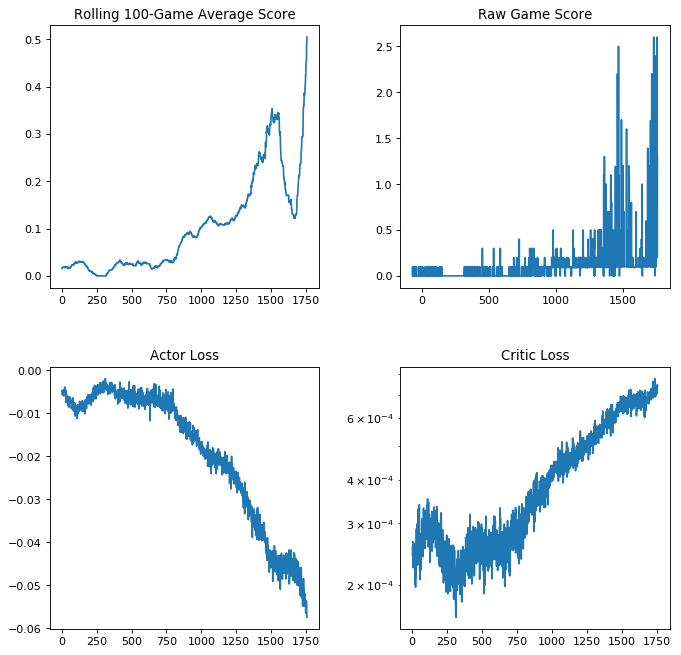

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

#import data
with open('./data/data_episode_metric.pickle', 'rb') as fp:
    episode_metric = pickle.load(fp)
with open('./data/data_rolling_metric.pickle', 'rb') as fp:
    rolling_metric = pickle.load(fp)
with open('./data/data_absolute_metric.pickle', 'rb') as fp:
    absolute_metric = pickle.load(fp)
with open('./data/data_a_loss_metric.pickle', 'rb') as fp:
    a_loss = pickle.load(fp)
with open('./data/data_c_loss_metric.pickle', 'rb') as fp:
    c_loss = pickle.load(fp)
    
#Create a plot containing the rolling average score, the raw score, the critic loss, and the actor loss
fig = plt.figure(figsize = (10, 10), dpi = 80)
ax1 = plt.subplot2grid((2, 2), (0, 0), rowspan = 1, colspan = 1)
ax2 = plt.subplot2grid((2, 2), (0, 1), rowspan = 1, colspan = 1)
ax3 = plt.subplot2grid((2, 2), (1, 0), rowspan = 1, colspan = 1)
ax4 = plt.subplot2grid((2, 2), (1, 1), rowspan = 1, colspan = 1)
plt.subplots_adjust(wspace = 0.3, hspace = 0.3)

average_x = episode_metric[-episode_metric[-1]:]
average_y = rolling_metric[-episode_metric[-1]:]
ax1.plot(average_x, average_y)
ax1.set_title("Rolling 100-Game Average Score", fontsize = 12)

ax2.plot(episode_metric, absolute_metric)
ax2.set_title("Raw Game Score", fontsize = 12)

ax3.plot(episode_metric[-episode_metric[-1]:], a_loss[-episode_metric[-1]:])
#ax3.set_yscale('log')
ax3.set_title("Actor Loss", fontsize = 12)

ax4.plot(episode_metric[-episode_metric[-1]:], c_loss[-episode_metric[-1]:])
ax4.set_yscale('log')
ax4.set_title("Critic Loss", fontsize = 12)

## Discussion of results and other ideas for future improvement
The results above are described in this section. There are four graphs, each corresponding to different metrics.
In the top left, the rolling 100-game averaged score is plotted. 
In the top right, the raw score of each episode is plotted. The score for each episode is picked as the higher score between the two agents. 
In the bottom left, the averaged actor loss is plotted. Each agent has its own actor, so the losses are collected and averaged at the end of each time step.
In the bottom right, the shared critic loss is plotted. It is important to note that the y-axis is scaled logarithmically to better show the loss trend over time.

Learning appears to start pretty slow. For the first 250 episodes (on the graphs, this is listed from -100 to 150 as the x-axis), because the noise level is so high, learning seems fairly non-existant. Then for a hundred episodes or so after noise is removed from actions, the agents temporarily perform poorly with a huge block of games with no rewards. Finally, learning increases fairly rapidly until the environment is solved.

Some ideas for future improvement could be additional tweaking of the hyperparameters. When performing experiments, some of the parameters which appeared to have a big influence on the convergence of a solution was the tau (soft update rate), the network architecture including the number of hidden layers, the number of nodes in each hidden layer, the activation functions, and most importantly, the weight initialization. 

One possibility for helping to prevent divergence in the neural networks would be to introduce bipolar activations: https://arxiv.org/pdf/1709.04054.pdf. This helps keep the mean of the gradients close to zero by randomly multiplying a proportion of half of the output of some other activation function (ReLU for instance) by -1. 

Finally, multiple pairs of agents could be trained in parallel to speed up learning by rapid exploration at the beginning which could lead to finding a winning policy in fewer episodes. In the current implementation, a solution was found after 1756 episodes.